In [24]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [25]:
import tensorflow as tf
from tensorflow.keras import layers

# Tamaño y batch
img_size = (48, 48)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Ruta del dataset
dataDir = "dataset/train"

# Carga de datos
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataDir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size
)

original_train_ds = tf.keras.utils.image_dataset_from_directory(
    dataDir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size
)

# Clases
class_names = original_train_ds.class_names

# Normalización
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Pipeline optimizado
train_ds = original_train_ds.cache().shuffle(1000).map(
    lambda x, y: (data_augmentation(normalization_layer(x), training=True), y),
    num_parallel_calls=AUTOTUNE
).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.cache().map(
    lambda x, y: (normalization_layer(x), y),
    num_parallel_calls=AUTOTUNE
).prefetch(buffer_size=AUTOTUNE)

# Verifica GPU
print("Dispositivos GPU disponibles:", tf.config.list_physical_devices('GPU'))


Found 28709 files belonging to 6 classes.
Using 5741 files for validation.
Found 28709 files belonging to 6 classes.
Using 22968 files for training.
Dispositivos GPU disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Entrenamiento:

In [26]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

train_ds = train_ds.map(lambda x, y: (data_augmentation(x,training=True), y))

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

model = models.Sequential([
    keras.layers.Input(shape=(48, 48, 1)),

    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)


y_train = []
for _, labels in train_ds.unbatch():
    y_train.append(labels.numpy())
y_train = np.array(y_train)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# Callback para detener entrenamiento si no mejora
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

# Callback para guardar el mejor modelo
checkpoint = ModelCheckpoint(
    "best_model.h5",          # nombre del archivo
    monitor='val_loss',       # métrica a vigilar
    save_best_only=True,      # solo guarda si mejora
    verbose=1
)

# Entrenamiento con callbacks
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint],  # aquí incluyes ambos
    class_weight=class_weights_dict
)


Epoch 1/20
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1754 - loss: 3.5754
Epoch 1: val_loss improved from inf to 1.90610, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.1754 - loss: 3.5721 - val_accuracy: 0.2083 - val_loss: 1.9061
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1913 - loss: 1.8619
Epoch 2: val_loss improved from 1.90610 to 1.82070, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - accuracy: 0.1913 - loss: 1.8619 - val_accuracy: 0.1942 - val_loss: 1.8207
Epoch 3/20
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2029 - loss: 1.7826
Epoch 3: val_loss improved from 1.82070 to 1.77562, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.2029 - loss: 1.7826 - val_accuracy: 0.2068 - val_loss: 1.7756
Epoch 4/20
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2127 - loss: 1.7667
Epoch 4: val_loss improved from 1.77562 to 1.70883, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.2127 - loss: 1.7667 - val_accuracy: 0.2498 - val_loss: 1.7088
Epoch 5/20
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2549 - loss: 1.6995
Epoch 5: val_loss did not improve from 1.70883
718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.2550 - loss: 1.6994 - val_accuracy: 0.2169 - val_loss: 1.9307
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3230 - loss: 1.6394
Epoch 6: val_loss improved from 1.70883 to 1.59682, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.3230 - loss: 1.6394 - val_accuracy: 0.3586 - val_loss: 1.5968
Epoch 7/20
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3580 - loss: 1.5950
Epoch 7: val_loss improved from 1.59682 to 1.57062, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.3580 - loss: 1.5949 - val_accuracy: 0.3667 - val_loss: 1.5706
Epoch 8/20
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3890 - loss: 1.5551
Epoch 8: val_loss improved from 1.57062 to 1.43620, saving model to best_model.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.3890 - loss: 1.5550 - val_accuracy: 0.4433 - val_loss: 1.4362
Epoch 9/20
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4023 - loss: 1.5372
Epoch 9: val_loss did not improve from 1.43620
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.4023 - loss: 1.5372 - val_accuracy: 0.2660 - val_loss: 1.8826
Epoch 10/20
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4230 - loss: 1.4900
Epoch 10: val_loss did not improve from 1.43620
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.4230 - loss: 1.4899 - val_accuracy: 0.3496 - val_loss: 1.7069
Epoch 11/20
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4373 - loss: 1.4695
Epoch 11: val_loss did not improve from 1.43620
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.4374 - loss: 1.4694 - val_accuracy: 0.4353 - val_loss: 1.4990
Epoch 12/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4453 - loss: 1.4496
Epoch 12: val_loss did not imp

718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.4699 - loss: 1.4221 - val_accuracy: 0.4982 - val_loss: 1.3240
Epoch 15/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4717 - loss: 1.3971
Epoch 15: val_loss did not improve from 1.32398
718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.4717 - loss: 1.3971 - val_accuracy: 0.4865 - val_loss: 1.3636
Epoch 16/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4770 - loss: 1.3903
Epoch 16: val_loss did not improve from 1.32398
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.4770 - loss: 1.3903 - val_accuracy: 0.4844 - val_loss: 1.3534
Epoch 17/20
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4791 - loss: 1.3786
Epoch 17: val_loss did not improve from 1.32398
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.4791 - loss: 1.3786 - val_accuracy: 0.4928 - val_loss: 1.3664
Epoch 18/20
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4926 - loss: 1.3635
Epoch 18: val_loss did not i

## Matriz de confusion:

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predicciones
y_pred = np.argmax(model.predict(val_ds), axis=1)

# Etiquetas verdaderas
y_true = []
for _, labels in val_ds.unbatch():
    y_true.append(labels.numpy())
y_true = np.array(y_true)

# Reporte
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))



180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
[[ 350   43   74   66  232   94]
 [ 164   49   46   83  216  252]
 [ 148    6 1024   39   88  103]
 [  62   38  136  412  298   95]
 [ 171   45   83  142  477   60]
 [  31   15   21   12   18  548]]
              precision    recall  f1-score   support

       angry       0.38      0.41      0.39       859
        fear       0.25      0.06      0.10       810
       happy       0.74      0.73      0.73      1408
     neutral       0.55      0.40      0.46      1041
         sad       0.36      0.49      0.41       978
    surprise       0.48      0.85      0.61       645

    accuracy                           0.50      5741
   macro avg       0.46      0.49      0.45      5741
weighted avg       0.49      0.50      0.47      5741



## Evaluacion de la presicion del modelo


In [29]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/test",
    image_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size
)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=AUTOTUNE)


test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.2f}")


Found 7178 files belonging to 6 classes.
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5034 - loss: 1.3158
Test accuracy: 0.51


## Grafica para ver la presicion del modelo:


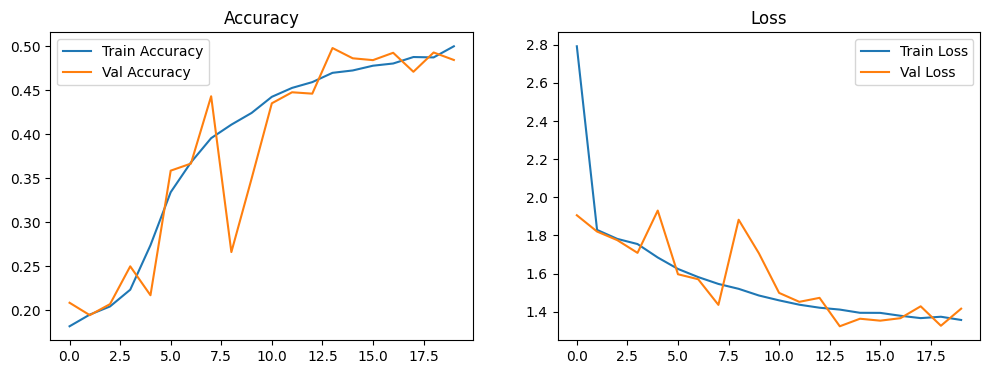

In [30]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


## Descargar el modelo:
ya que lo estaba haciendo directamente desde google colab, con este segmento descargaba el modelo desde colab


In [ ]:
from google.colab import files
files.download("best_model.h5")
